# Lattice tracking

In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from pytao import Tao
import matplotlib.pyplot as plt
tkwargs = {
    "dtype" : torch.double
}
import time
import os
np.set_printoptions(precision= 15, suppress=False)
torch.set_printoptions(precision= 15, sci_mode=True)
import pytao
torch.__version__, np.__version__, pytao.__version__

('1.11.0', '1.22.4', '0.1.7')

In [2]:
from pathlib import Path

def find_repo(path):
    "Find repository root from the path's parents"
    for path in Path(path).parents:
        # Check whether "path/.git" exists and is a directory
        git_dir = path / ".git"
        if git_dir.is_dir():
            return path

import os
nb_dir = os.getcwd()
# Find the repo root where the script is
repo_path = str(find_repo(nb_dir))
repo_path

'/home/jg2347/Repositories/Bmad-X'

## Lattice one particle test

In [3]:
# Create incoming particle

from bmadx import M_ELECTRON, Particle

s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*M_ELECTRON # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = Particle(*tvec1,ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.109989500000000e+05, dtype=torch.float64))

In [4]:
# Create drift

from bmadx import Drift

L_d = 1.0 # Drift length in m
d1 = Drift(torch.tensor(L_d, **tkwargs))

In [5]:
# Create quad

from bmadx import Quadrupole

def torch_quadrupole(L: torch.Tensor, K1: torch.Tensor, NUM_STEPS=1,
                     X_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                     Y_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                     TILT: torch.Tensor=torch.tensor(0.0,**tkwargs)):
    return Quadrupole(L=L, K1=K1, NUM_STEPS=NUM_STEPS, X_OFFSET=X_OFFSET,
                      Y_OFFSET=Y_OFFSET, TILT=TILT)

L_q = 0.1  # quad length in m
K1 = 10  # Quad focusing strength. Positive is focusing in x
q1 = torch_quadrupole(L=torch.tensor(L_q, **tkwargs), K1=torch.tensor(K1, **tkwargs))

In [6]:
# Lattice example

from bmadx import track_a_lattice

lattice = [d1, q1, d1, q1, d1]  # lattice is a list of elements

# track_a_lattice returns list of particle coordinates after each element:
p_list = track_a_lattice(p_in, lattice)
x_list = [torch.hstack(coords[:6]).detach() for coords in p_list]

# Outgoing particle after complete lattice:
x_py = torch.hstack(track_a_lattice(p_in, lattice)[-1][:6]).detach()
# alternative: x_list[-1]
x_py

tensor([-2.281967961209991e-03, -4.896330349656308e-03, -2.543913165908659e-02,
        -1.497282967847466e-02, 1.847324681974169e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [7]:
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_drift_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=5)

In [8]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([-2.281967961209990e-03, -4.896330349656310e-03, -2.543913165908660e-02,
        -1.497282967847470e-02, 1.847324681974170e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [9]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Lattice Jacobian test

In [10]:
f_driftquadrupole = lambda x: track_a_lattice(Particle(*x, ts, tp0c, tmc2), lattice)[-1][:6]
J = jacobian(f_driftquadrupole, tvec1)

In [11]:
# autodiff Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[-1.032202390317458e+00, -7.256968115101181e-02,  2.336717479636538e-04,
          4.049003895819779e-04,  0.000000000000000e+00,  8.218283945153969e-03],
        [-9.000515317112638e-01, -1.032080978292848e+00, -1.067067115329933e-05,
         -1.900037293643618e-05,  0.000000000000000e+00,  5.547564231500580e-04],
        [-8.812732879846703e-05, -9.339294371369415e-05,  5.457258390307320e+00,
          9.071019578396722e+00,  0.000000000000000e+00,  3.361265895544615e-02],
        [-1.067067115329933e-05, -9.954618543668099e-06,  3.172268131080336e+00,
          5.456165751278677e+00,  0.000000000000000e+00,  9.391470418309955e-03],
        [-6.823789171283308e-03, -8.441133541388406e-03,  5.537646874208031e-02,
          9.820564579614072e-02,  1.000000000000000e+00,  9.919963196451456e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [12]:
# Bmad formula Jacobian
lat_tao = tao.matrix(0,5)
mat_tao = torch.tensor(lat_tao['mat6'], **tkwargs)
mat_tao

tensor([[-1.032202390317460e+00, -7.256968115101139e-02,  2.336717479636540e-04,
          4.049003895819780e-04,  0.000000000000000e+00,  8.218283945153960e-03],
        [-9.000515317112640e-01, -1.032080978292850e+00, -1.067067115329930e-05,
         -1.900037293643620e-05,  0.000000000000000e+00,  5.547564231500580e-04],
        [-8.812732879846700e-05, -9.339294371369409e-05,  5.457258390307320e+00,
          9.071019578396720e+00,  0.000000000000000e+00,  3.361265895544610e-02],
        [-1.067067115329930e-05, -9.954618543668099e-06,  3.172268131080340e+00,
          5.456165751278680e+00,  0.000000000000000e+00,  9.391470418309950e-03],
        [-6.823789171283310e-03, -8.441133541388410e-03,  5.537646874208030e-02,
          9.820564579614070e-02,  1.000000000000000e+00,  9.919963196451461e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [13]:
# close to Tao result?
torch.allclose(mat_py, mat_tao, atol=0, rtol=1.0e-14)

True

## Multi-particle propagation through lattice

In [14]:
# Particle bunch with Gaussian distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
bunch_in = Particle(*sample.T, ts, tp0c, tmc2)

In [15]:
bunch_out = track_a_lattice(bunch_in, lattice)

In [16]:
# some beam properties up and downstream
torch.std(bunch_out[0].y),torch.std(bunch_out[-1].y)

(tensor(9.965035397978051e-04, dtype=torch.float64),
 tensor(1.451631809951503e-02, dtype=torch.float64))

## Stub element test

In [17]:
from bmadx import stub_element, stub_lattice

In [18]:
# divide a quad into 10 parts
divided_quad = stub_element(q1, 10)
divided_quad

[Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor

## Plotting using stub_lattice

In [19]:
# make a quadrupole triplet
L_d = 1.5  # Drift length in m
d1 = Drift(torch.tensor(L_d, **tkwargs)) # drift
L_q = 0.1  # Quadrupole length in m
K1 = 10  # Quadrupole strengths
NUM_STEPS = 1
q1 = torch_quadrupole(L=torch.tensor(L_q,**tkwargs), K1=torch.tensor(K1, **tkwargs))  # x-focusing
q2 = torch_quadrupole(L=torch.tensor(L_q,**tkwargs), K1=torch.tensor(-K1, **tkwargs))  # y-focusing
lattice = [d1, q1, d1, q2, d1, q1, d1]

# stub each element into n equal parts each
n=50
stubbed_lattice = stub_lattice(lattice, n)

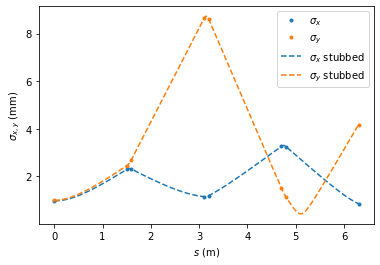

In [20]:
# compare plots using stubbed and nonstubbed lattice: 
# non-stubbed lattice only records particles at the entrance and exit of each element
all_p = track_a_lattice(bunch_in, lattice)
all_p_stubbed = track_a_lattice(bunch_in, stubbed_lattice)
stdx = np.array([torch.std(par.x).item() for par in all_p])
stdy = np.array([torch.std(par.y).item() for par in all_p])
stdx_stubbed = np.array([torch.std(par.x).item() for par in all_p_stubbed])
stdy_stubbed = np.array([torch.std(par.y).item() for par in all_p_stubbed])
s = np.array([par.s.item() for par in all_p])
s_stubbed = np.array([par.s.item() for par in all_p_stubbed])
plt.plot(s, stdx*1000, '.', color='C0', label=r'$\sigma_x$')
plt.plot(s, stdy*1000, '.', color='C1', label=r'$\sigma_y$')
plt.plot(s_stubbed, stdx_stubbed*1000, color='C0', linestyle='--', label=r'$\sigma_x$ stubbed')
plt.plot(s_stubbed, stdy_stubbed*1000, color='C1', linestyle='--',label=r'$\sigma_y$ stubbed')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()